In [1]:
from src.utils.PathManager import Paths as Path 
from src.utils.Visualisation import plot_ROC_simple
from src.utils.BayesianLabel import BayesianLabeler as Labeller 
from src.utils.FeatureExtractor import *
import pandas as pd 
import numpy as np 
from datetime import timedelta
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [2]:
well_code = "POND1"

In [3]:
data = FeatureExtractor.get_data(well_code)

In [4]:
minV = FeatureExtractor.get_minimum_feature(data['agg_df'],'ROC_VOLTAGE')

In [5]:
r = FeatureExtractor.get_relative_performance(minV.to_frame(), "ROC_VOLTAGE",window=90)

In [6]:
r[~r.isnull()]

2016-09-27    0.930748
2016-09-28    0.921392
2016-09-29    0.926089
2016-09-30    0.991038
2016-10-01    0.997079
                ...   
2020-08-17    0.993698
2020-08-18    0.995598
2020-08-19    0.988847
2020-08-20    0.988847
2020-08-21    1.000000
Name: ROC_VOLTAGE, Length: 1079, dtype: float64

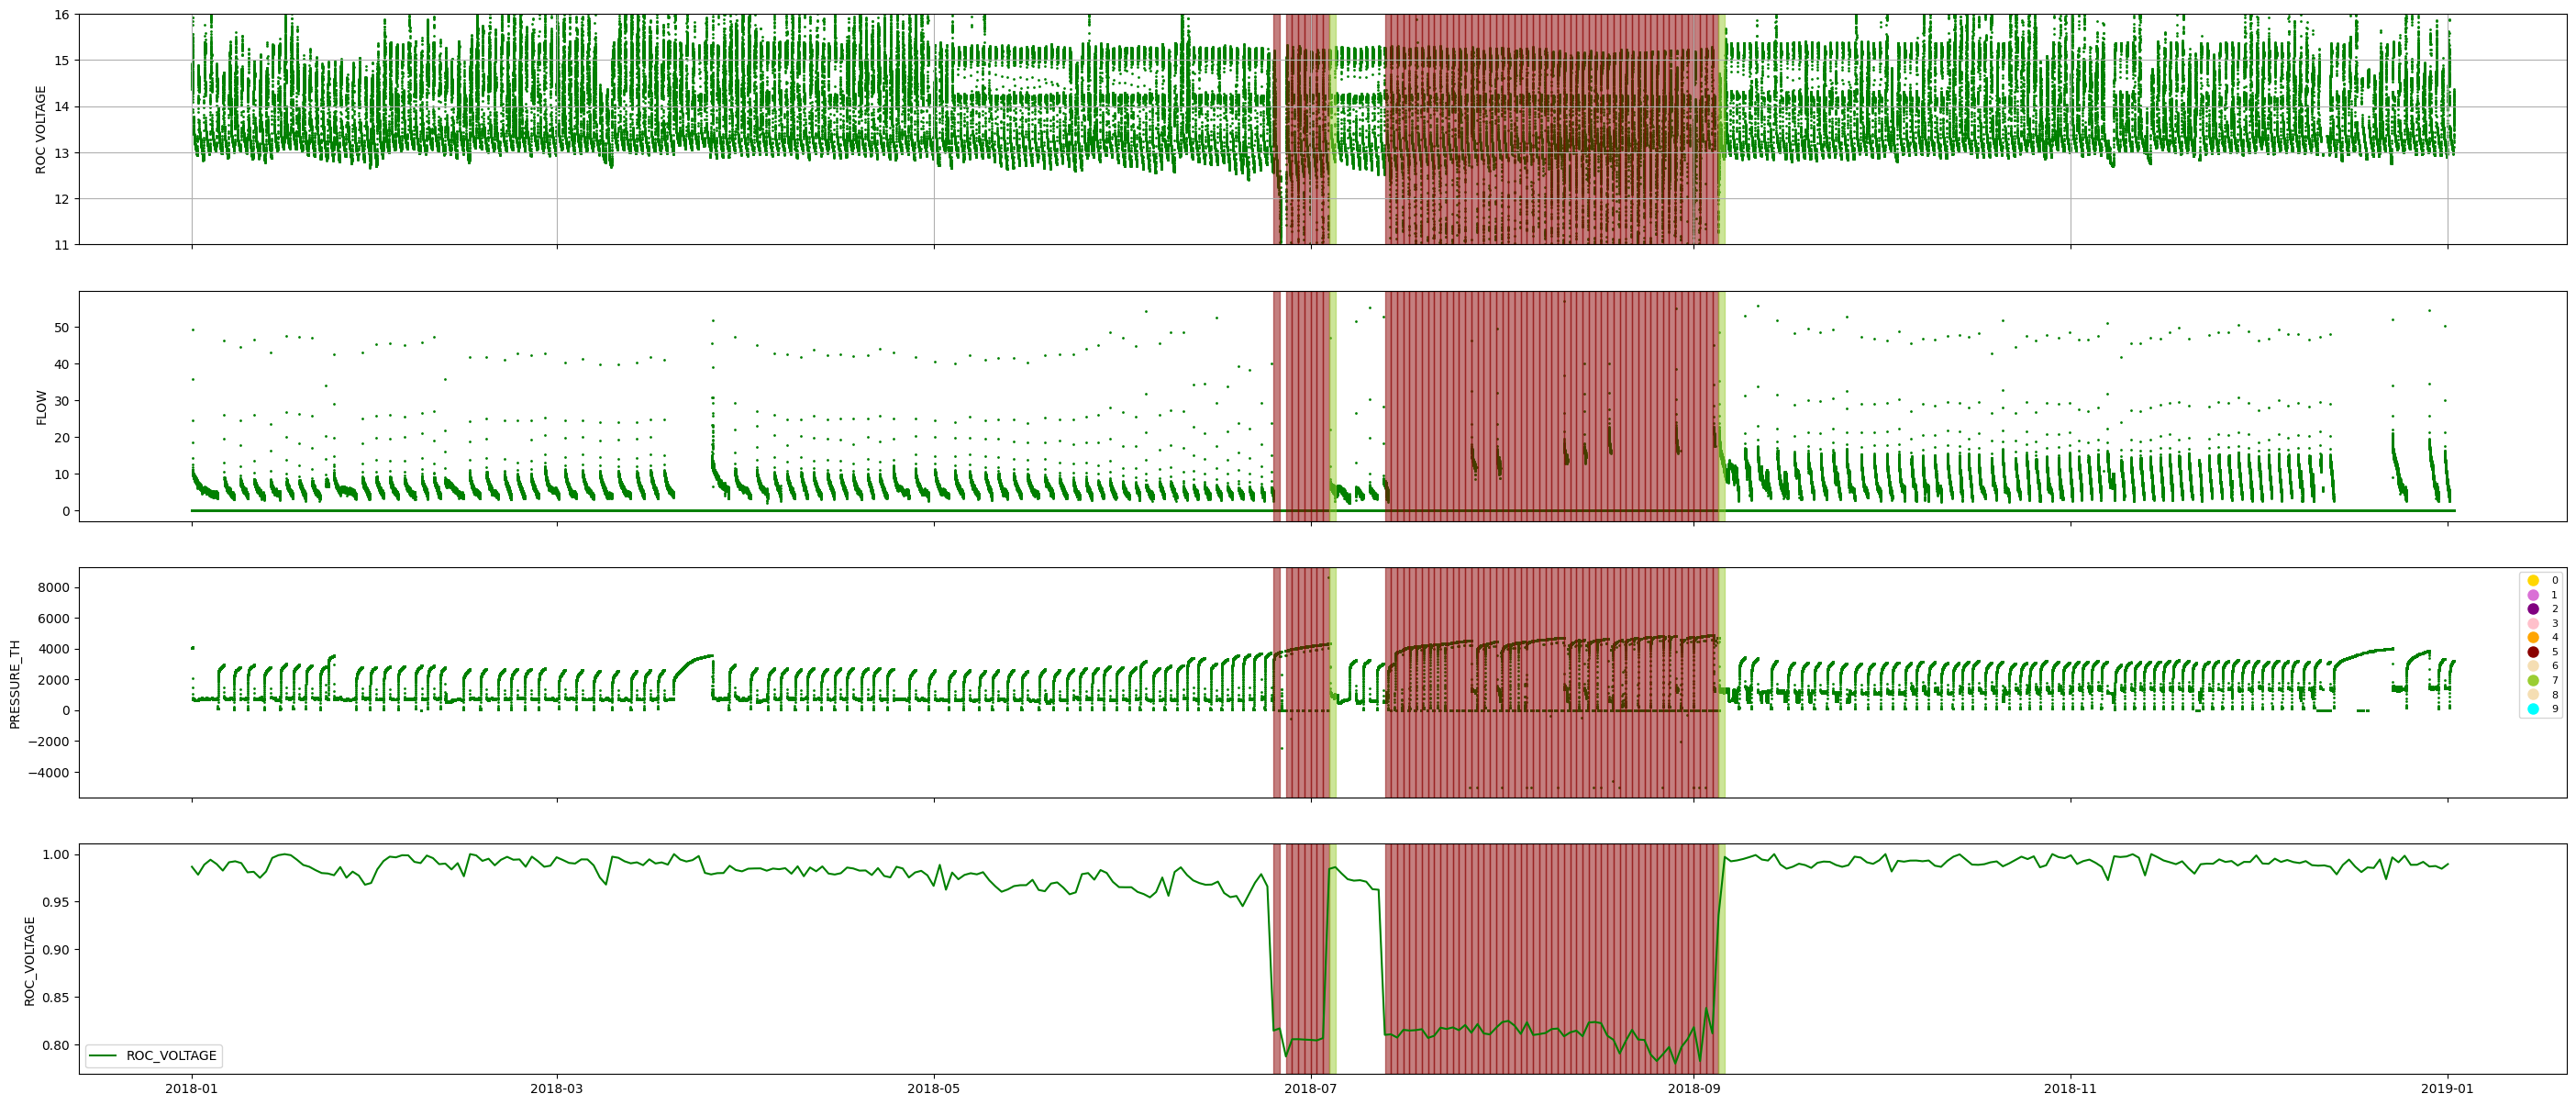

In [15]:
plot_ROC_simple(data["raw_df"],data["label_df"],start='2018-01-01',end='2019-01-01',ylim={'ROC_VOLTAGE':[11,16]},generated_feature_df=r.to_frame())
plt.show()

In [11]:
integralV = FeatureExtractor.get_integral_feature(data['agg_df'],'ROC_VOLTAGE')

In [9]:
r_integral = FeatureExtractor.get_relative_performance(integral.to_frame(), "ROC_VOLTAGE",window=90)

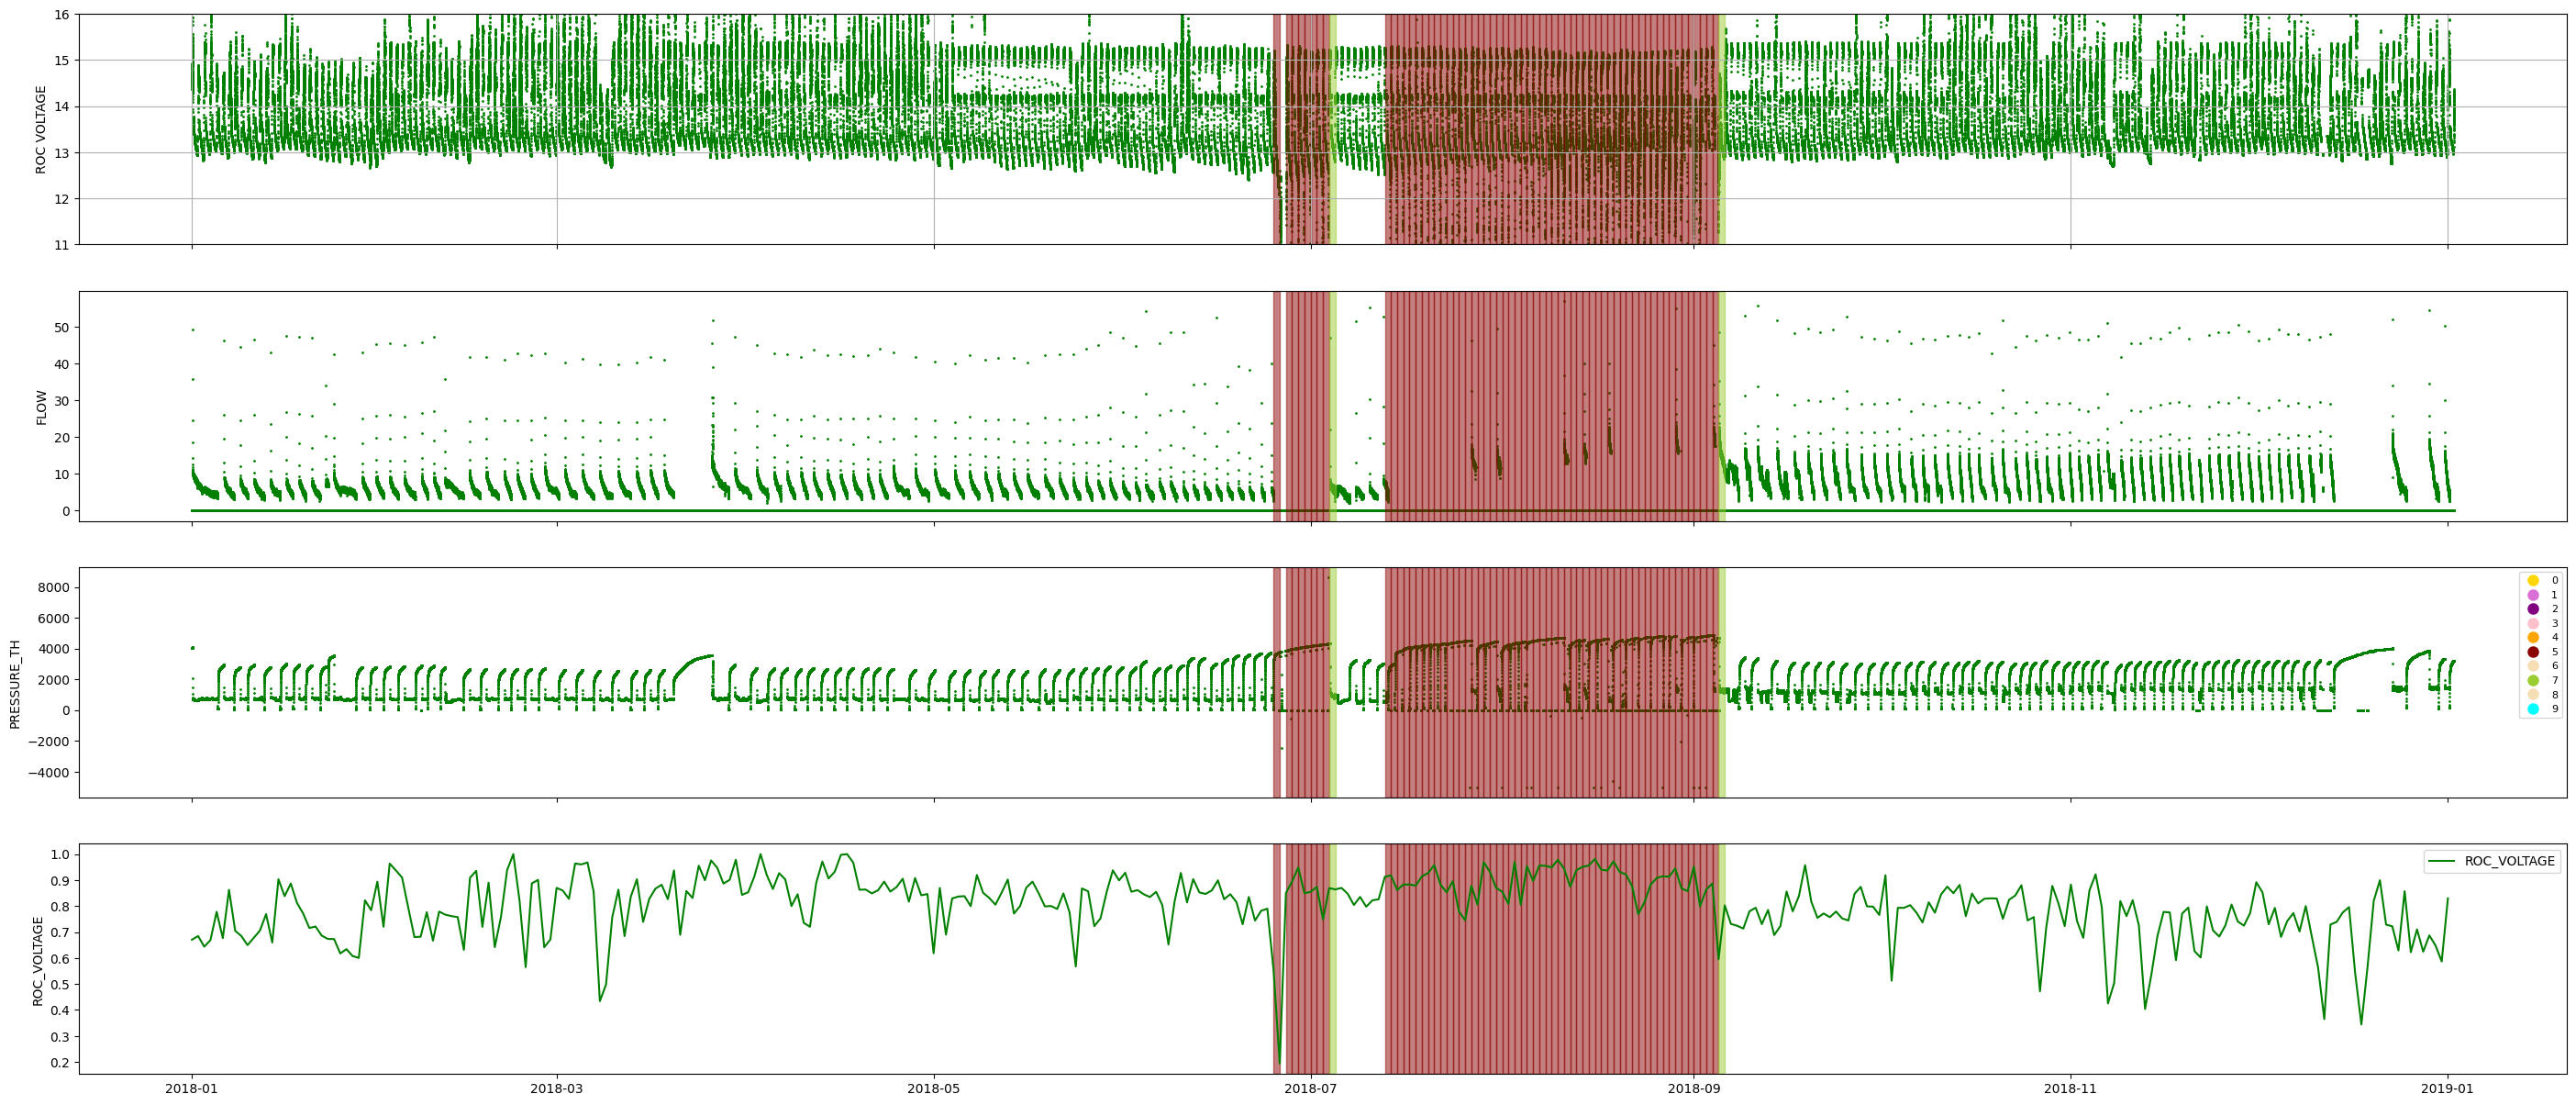

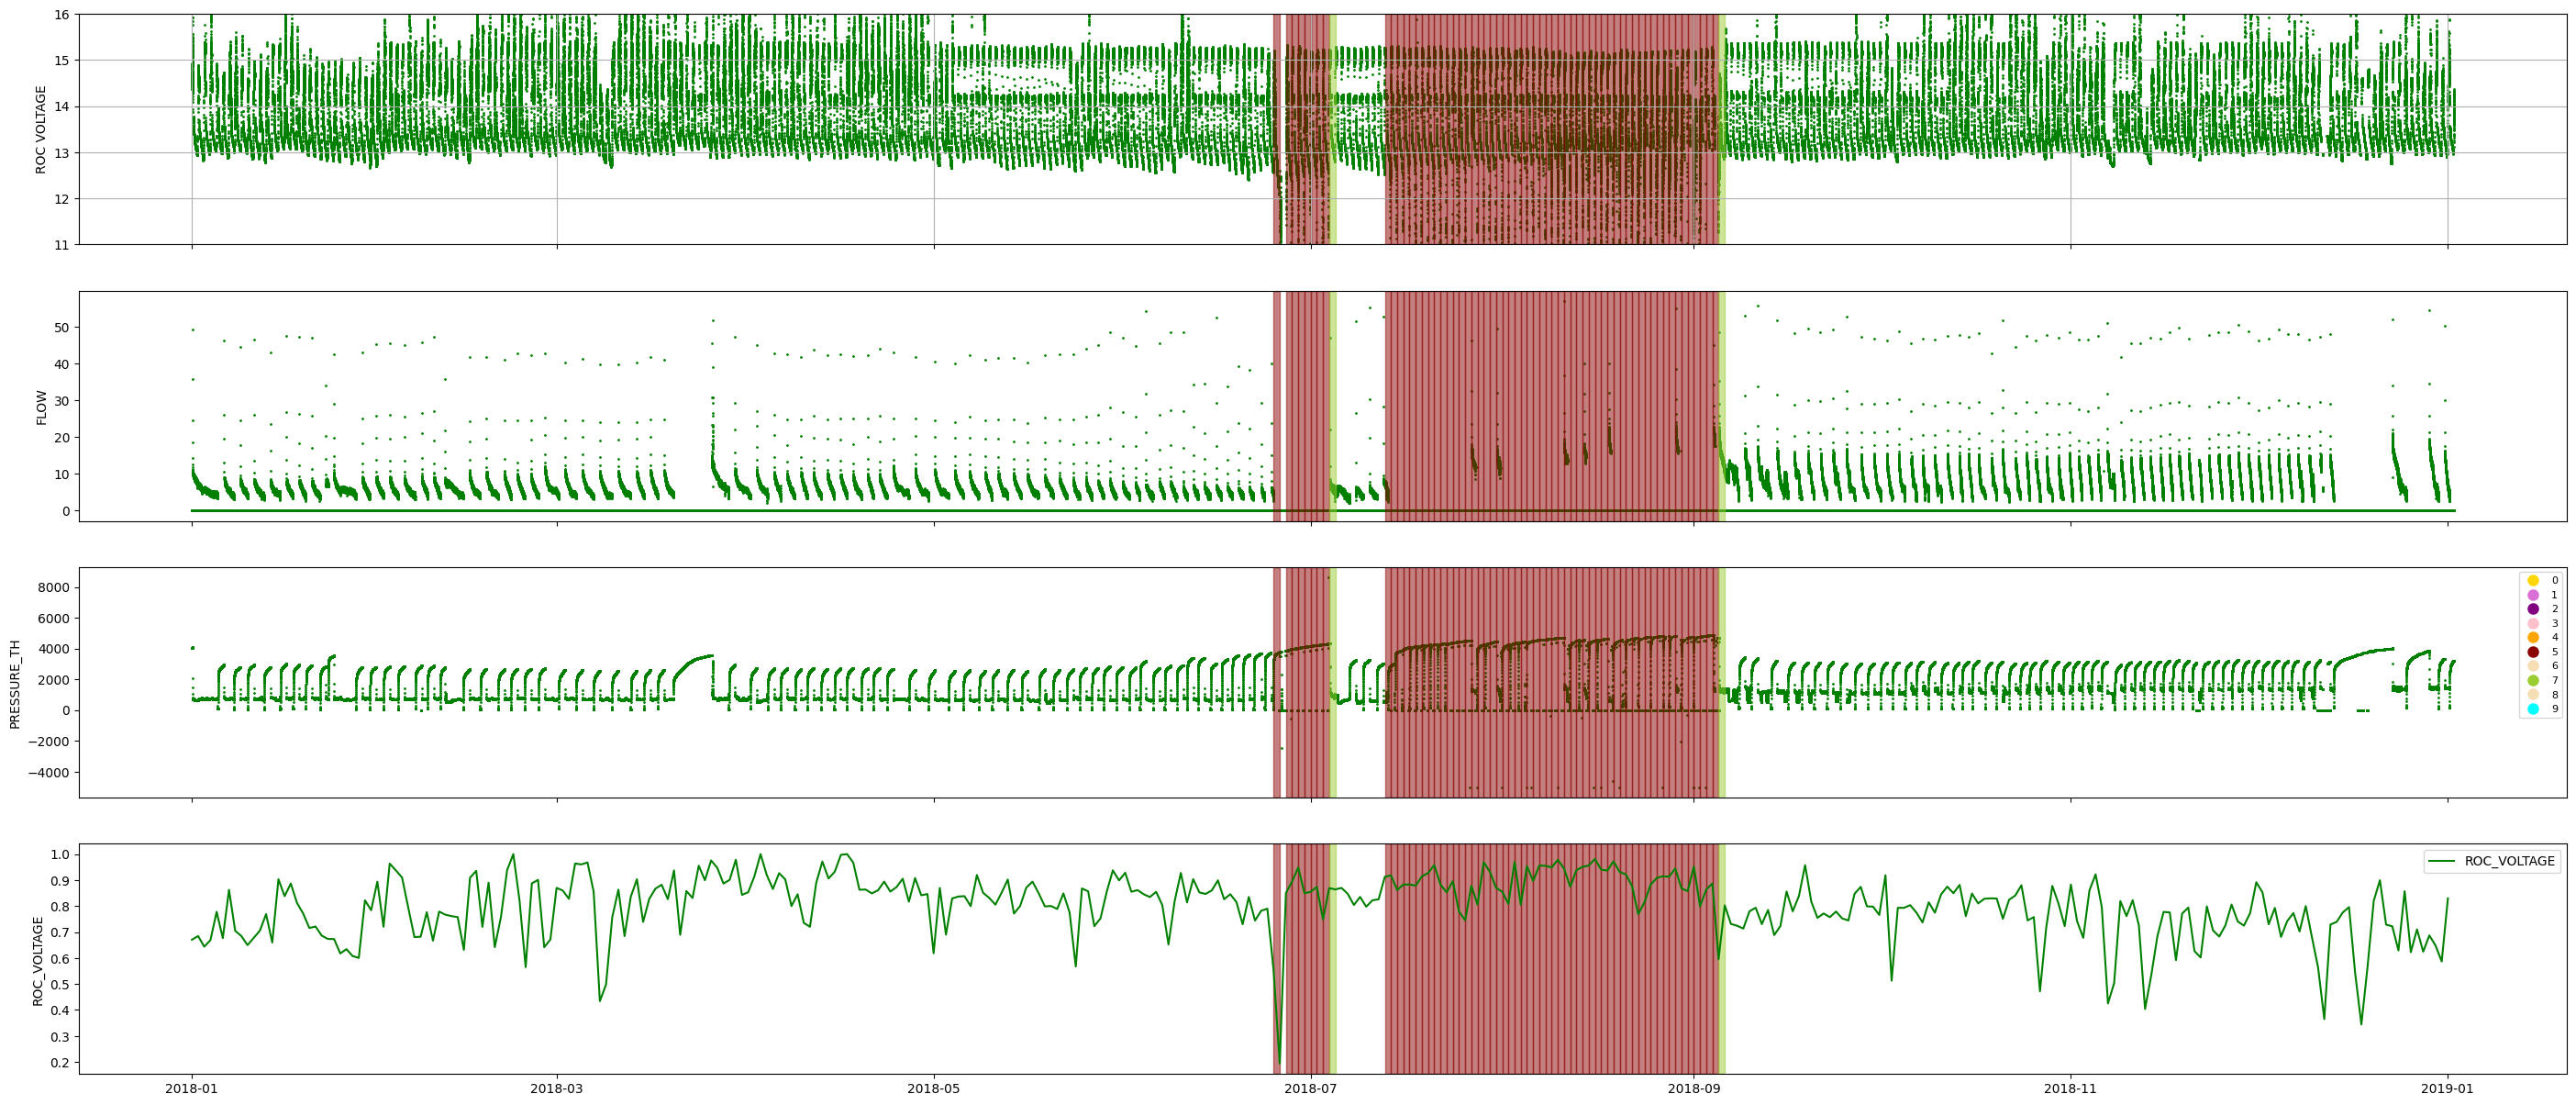

In [10]:
plot_ROC_simple(data["raw_df"],data["label_df"],start='2018-01-01',end='2019-01-01',ylim={'ROC_VOLTAGE':[11,16]},generated_feature_df=r_integral.to_frame())
